# Cubic spline interpolation

На отрезке $[-2, 2]$ задана функция $f_{1}(x) = cos(2x)$. Вычислить значения функции в равноотстоящих узлах ${x_{i} = a + ih|i=$

In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pandas import Series
from pandas import DataFrame

In [229]:
A, B = [-2,2]
N = 15
h = (B-A)/N
def f1(x):
    return np.cos(2*x)
def f1Der(x):
    return -2*np.sin(2*x)

In [230]:
def equalNodes(n):
    return np.array([A+(B-A)*i/n for i in range(0,n+1)])
nodes = equalNodes(N)
nodes

array([-2.        , -1.73333333, -1.46666667, -1.2       , -0.93333333,
       -0.66666667, -0.4       , -0.13333333,  0.13333333,  0.4       ,
        0.66666667,  0.93333333,  1.2       ,  1.46666667,  1.73333333,
        2.        ])

In [231]:
def fillNodes(nodes,f1):
    df = DataFrame({"x" : nodes, "f" : f1(nodes)})
    return df
df = fillNodes(nodes,f1)
df

,x,f
0,-2.000000,-0.653644
1,-1.733333,-0.947627
2,-1.466667,-0.978392
3,-1.200000,-0.737394
4,-0.933333,-0.291572
5,-0.666667,0.235238
6,-0.400000,0.696707
7,-0.133333,0.964655
8,0.133333,0.964655
9,0.400000,0.696707


In [232]:
def buildSLE(df, f1Der):
    n = len(df)
    c,d,e,b = map(np.zeros, [n]*4)
    d[0] = h/3
    e[0] = h/6
    b[0] = (df.loc[1, "f"] - df.loc[0, "f"])/h - f1Der(df.loc[0,"x"])
    for i in range (1,n-1):
        c[i] = h/6
        d[i] = 2*h/3
        e[i] = h/6
        b[i] = (df.loc[i+1, "f"]-2*df.loc[i, "f"] + df.loc[i-1, "f"])/h
    c[-1] = h/6
    d[-1] = h/3
    b[-1] =  f1Der(df.loc[n-1,"x"]) - (df.loc[n-1, "f"] - df.loc[n-2, "f"])/h 
    return (c,d,e,b)
matrix = buildSLE(df, f1Der)
matrix

(array([0.        , 0.04444444, 0.04444444, 0.04444444, 0.04444444,
        0.04444444, 0.04444444, 0.04444444, 0.04444444, 0.04444444,
        0.04444444, 0.04444444, 0.04444444, 0.04444444, 0.04444444,
        0.04444444]),
 array([0.08888889, 0.17777778, 0.17777778, 0.17777778, 0.17777778,
        0.17777778, 0.17777778, 0.17777778, 0.17777778, 0.17777778,
        0.17777778, 0.17777778, 0.17777778, 0.17777778, 0.17777778,
        0.08888889]),
 array([0.04444444, 0.04444444, 0.04444444, 0.04444444, 0.04444444,
        0.04444444, 0.04444444, 0.04444444, 0.04444444, 0.04444444,
        0.04444444, 0.04444444, 0.04444444, 0.04444444, 0.04444444,
        0.        ]),
 array([ 0.41116698,  0.9870685 ,  1.01911419,  0.76808495,  0.30370809,
        -0.24502845, -0.7257045 , -1.00480476, -1.00480476, -0.7257045 ,
        -0.24502845,  0.30370809,  0.76808495,  1.01911419,  0.9870685 ,
         0.41116698]))

In [233]:
def sweepMethod(c, d, e, b):
    n = len(c)
    x = np.zeros(n)
    for i in range(1,n):
        d[i] = d[i] - e[i-1]*c[i]/d[i-1]
        b[i] = b[i] - b[i-1]*c[i]/d[i-1]
    x[-1] = b[-1]/d[-1]
    for i in range(n-2, -1, -1):
        x[i] = (b[i] - e[i]*x[i+1])/d[i]
    return x
c,d,e,b = matrix
M = Series(sweepMethod(c,d,e,b))
M

0     2.686262
1     3.878734
2     4.007844
3     3.019958
4     1.194237
5    -0.963472
6    -2.853489
7    -3.950924
8    -3.950924
9    -2.853489
10   -0.963472
11    1.194237
12    3.019958
13    4.007844
14    3.878734
15    2.686262
dtype: float64

In [234]:
def findSplane(df, M, x):
    xind = np.floor((x-a)/h)
    xind[xind==N] = N-1
    return Series([M[xi]*((df.loc[(xi+1), "x"] - xv)**3)/(6*h)+
                   + M[xi+1]*((xv-df.loc[xi,"x"])**3)/(6*h) + 
                   (df.loc[xi,"f"]-h*h/6*M[xi])*(df.loc[xi+1, "x"]-xv)/h +
                   +(df.loc[xi+1, "f"] - h*h/6*M[xi+1])*(xv-df.loc[xi,"x"])/h for xi,xv in zip(xind,x)], index = x)
Values = Series(findSplane(df, M, equalNodes(100)))
Values.tail(10)

1.64   -0.990240
1.68   -0.976140
1.72   -0.955792
1.76   -0.929242
1.80   -0.896677
1.84   -0.858384
1.88   -0.814647
1.92   -0.765754
1.96   -0.711991
2.00   -0.653644
dtype: float64

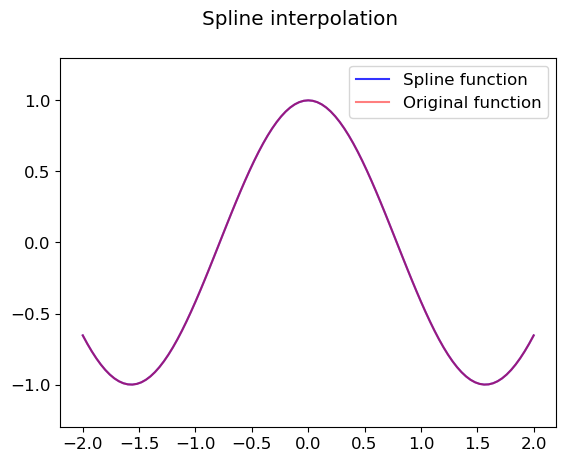

In [235]:
font = {"size" : 12}
matplotlib.rc('font', **font)
fig = plt.figure()
ax = fig.subplots()
fig.suptitle("Spline interpolation")
ax.plot(Values, alpha = 0.8, color = "blue", label = "Spline function")
ax.plot(Values.index, f1(Values.index), alpha = 0.5, color = "red", label = "Original function")
plt.ylim(-1.3, 1.3)
ax.legend()
fig.savefig("spline.png",dpi=200)

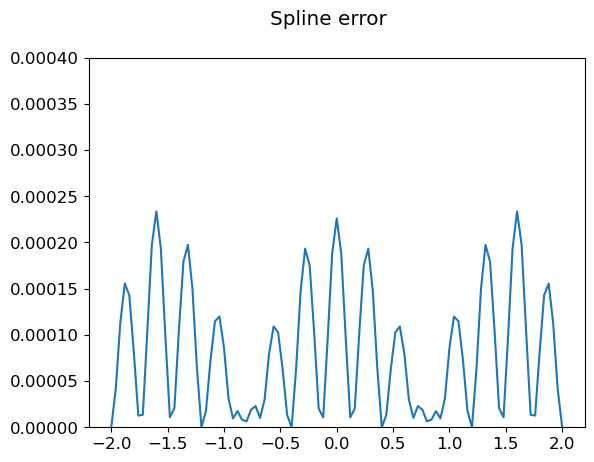

In [238]:
fig = plt.figure()
ax = fig.subplots()
plt.ylim(0,0.0004)
ax.plot(Values.index, np.abs(f1(Values.index) - Values))
fig.suptitle("Spline error")
fig.savefig("error_spline.png", dpi=200)

In [237]:
def findError(Values, f1):
    return np.max(Values.values - f1(Values.index))
findError(Values, f1)

0.0002336241715128473